# Assignment: Implementing MADDPG with the TorchRL Toolkit
#### Amir Kooshan Fattah Hesari - 401102191
In this task, you’ll implement the MADDPG algorithm — a method used to train multiple agents to learn and collaborate effectively.

To make things smoother, we’ll be using TorchRL, a library that simplifies building and training RL agents.

The assignment has two main goals:

1. Help you understand the key ideas behind MADDPG, especially the idea of centralized training (agents learn together) and decentralized execution (they act independently).

2. Introduce you to important TorchRL.

We’ve already set up the basic structure for you. Your job is to complete the missing pieces marked as TODOs. Before each coding step, we’ll explain what the MADDPG concept is and how to apply it using the right TorchRL tools.

In [ ]:
# Install dependencies
!pip3 install torchrl
!pip3 install vmas
!pip3 install tqdm
!apt-get update -y
!apt-get install -y x11-utils xvfb python3-opengl libgl1-mesa-glx libglu1-mesa
!pip install pyvirtualdisplay

## Imports

In [ ]:
import copy
import tempfile
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import pyvirtualdisplay
from PIL import Image
import numpy as np

from tensordict import TensorDictBase
from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import multiprocessing
from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer
from torchrl.envs import (
    check_env_specs,
    RewardSum,
    TransformedEnv,
    VmasEnv,
)
from torchrl.modules import (
    AdditiveGaussianModule,
    MLP,
    ProbabilisticActor,
    TanhDelta,
)
from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators
from tqdm import tqdm

# --- Setup Virtual Display ---
try:
    display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
    display.start()
    print("Virtual display started.")
except Exception as e:
    print(f"Could not start virtual display: {e}")

## Configuration

In [3]:
# General
seed = 0
is_fork = multiprocessing.get_start_method() == "fork"
device = torch.device(0) if torch.cuda.is_available() and not is_fork else torch.device("cpu")
torch.manual_seed(seed)
print(f"Using device: {device}")

# Vmas Environment
scenario_name = "navigation"
n_agents = 3
max_steps = 100  # Episode steps before done

# Sampling
frames_per_batch = 2000
n_iters = 1500
total_frames = frames_per_batch * n_iters
num_vmas_envs = frames_per_batch // max_steps

# Replay Buffer
memory_size = 2_000_000

# Training
n_optimiser_steps = 10
train_batch_size = 512
lr = 3e-4
max_grad_norm = 1.0

# DDPG Algorithm
gamma = 0.99
polyak_tau = 0.005

Using device: cuda:0


## Environment Setup

In [4]:
# Each agent is in its own group, so group_name == agent_name
custom_group_map = {f"agent_{i}": [f"agent_{i}"] for i in range(n_agents)}

# Create the vectorized Vmas environment
env = VmasEnv(
    scenario=scenario_name,
    num_envs=num_vmas_envs,
    continuous_actions=True,
    max_steps=max_steps,
    device=device,
    n_agents=n_agents,
    group_map=custom_group_map,
)

# Wrap the environment to sum rewards for each agent group
env = TransformedEnv(
    env,
    RewardSum(
        in_keys=env.reward_keys,
        reset_keys=["_reset"] * len(env.group_map.keys()),
    ),
)

# Print environment specs
print(f"group_map: {env.group_map}")
print("action_spec:", env.full_action_spec)
print("reward_spec:", env.full_reward_spec)
print("done_spec:", env.full_done_spec)
print("observation_spec:", env.observation_spec)

check_env_specs(env)

group_map: {'agent_0': ['agent_0'], 'agent_1': ['agent_1'], 'agent_2': ['agent_2']}
action_spec: Composite(
    agent_0: Composite(
        action: BoundedContinuous(
            shape=torch.Size([20, 1, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([20, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([20, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([20, 1]),
        data_cls=None),
    agent_1: Composite(
        action: BoundedContinuous(
            shape=torch.Size([20, 1, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([20, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([20, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
  

## Part 1 : Decentralized Actor

**1a. MADDPG Concept: The Agent's Brain**

In MADDPG, each agent has its own independent "actor" network. This network takes the agent's observation and decides which action to take. It's the "decentralized execution" part of the algorithm.

Your Task:

Implement the Actor Network using torchrl.modules.MLP. This will be a standard PyTorch nn.Module that serves as the brain for a single agent.

**1b. TorchRL vs TensorDictModule**

A standard nn.Module doesn't know how to interact with TorchRL's data structures. We need to wrap it with a TensorDictModule. This wrapper acts as an adapter, telling your MLP which data "key" to read its input from in the TensorDict and which "key" to write its output to.

Your Task:

Wrap your AgentMLP in a TensorDictModule.

## Policy Initialization

In [ ]:
# Part 1: Create the Actor Network using torchrl.modules.MLP
policy_modules = {}
for group, agents in env.group_map.items():
    agent_modules = {}
    for agent in agents:
        ### PART 1a ###
        agent_modules[agent] = MLP(
            in_features=env.observation_spec[(agent, "observation")].shape[-1],
            out_features=env.full_action_spec[(agent, "action")].shape[-1],
            num_cells=[256, 256],
            activation_class=nn.ReLU,
        )

    ### PART 1b ###
    agent_policy_modules = {}
    for agent in agents:
        agent_policy_modules[agent] = TensorDictModule(
            agent_modules[agent],
            in_keys=[(agent, "observation")],
            out_keys=[(agent, "param")],
        )
    policy_modules[group] = TensorDictSequential(*agent_policy_modules.values())

# Create Probabilistic Policies
policies = {}
for group, agents in env.group_map.items():
    agent_policies = []
    for agent in agents:
        agent_policies.append(
            ProbabilisticActor(
                module=policy_modules[group],
                spec=env.full_action_spec[agent, "action"],
                in_keys=[(agent, "param")],
                out_keys=[(agent, "action")],
                distribution_class=TanhDelta,
                distribution_kwargs={
                    "low": env.full_action_spec_unbatched[agent, "action"].space.low,
                    "high": env.full_action_spec_unbatched[agent, "action"].space.high,
                },
                return_log_prob=False,
            )
        )
    policies[group] = TensorDictSequential(*agent_policies)

# Create Target Policies for DDPG
target_policies = copy.deepcopy(policies)

# Create Exploration Policies: An AdditiveGaussianModule is appended to the policy to add noise for exploration
exploration_policies = {}
for group, _agents in env.group_map.items():
    first_actor = None
    for module in policies[group].modules():
        if isinstance(module, ProbabilisticActor):
            first_actor = module
            break
    if first_actor is None:
        raise RuntimeError("No ProbabilisticActor found in policies[group]")

    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=first_actor.spec,
            annealing_num_steps=total_frames // 3,
            action_key=(group, "action"),
            sigma_init=0.5,
            sigma_end=0.05,
        ),
    )
    exploration_policies[group] = exploration_policy



## Part 2: The Centralized Critic

**2a. MADDPG Concept: Using Global Information**

One of the key strengths of the MADDPG algorithm lies in its use of a centralized critic during training. Unlike the decentralized actors, which only have access to their individual observations, the centralized critic has access to the observations and actions of all agents. This broader perspective enables it to more accurately evaluate the quality of joint actions taken by the agents, which in turn leads to more stable and cooperative learning dynamics.

Your task:

Implement the CentralizedCritic using torchrl.modules.MLP. This network takes observations and actions of all agents, and return a scalar value representing the estimated state-action value. It's the "centralized training" part of the algorithm.

**2b. TorchRL Tool: Assembling Inputs with TensorDictModule**

How do we collect data from many different keys and feed it as one tensor to our critic? TensorDictModule can do more than just wrap a network; it can also perform operations. We can give it a list of in_keys and a lambda function to tell it how to combine them.

Your Task:

Create a TensorDictModule that gathers all observations and actions and concatenates them into a single tensor for the critic.

## Critic Network Initialization

In [ ]:
# Part 2: Create Centralized Critics using torchrl.modules.MLP
def create_centralized_critics():
    """Create centralized critic networks that observe global state and actions."""
    
    # Get all agents for global observation/action concatenation
    all_agents = list(env.group_map.keys())  # group == agent in this environment
    
    # Calculate total input dimensions for centralized critics
    global_obs_dim = _calculate_global_observation_dimension(all_agents)
    global_action_dim = _calculate_global_action_dimension(all_agents)
    total_critic_input_dim = global_obs_dim + global_action_dim
    
    # Create critic networks for each group
    critics = {}
    for group, agents in env.group_map.items():
        # Create MLP networks for each agent in the group
        critic_networks = _create_critic_mlp_networks(agents, total_critic_input_dim)
        
        # Wrap networks in TensorDictModules with input concatenation
        critic_modules = _create_critic_tensor_modules(agents, critic_networks, all_agents)
        
        # Combine all agent critics in the group
        critics[group] = TensorDictSequential(*critic_modules.values())
    
    # Move all networks to the appropriate device
    _move_networks_to_device(critics)
    
    print("Centralized critic networks created and moved to device.")
    return critics


def _calculate_global_observation_dimension(all_agents):
    """Calculate total dimension of concatenated observations from all agents."""
    return sum(
        env.observation_spec[(agent, "observation")].shape[-1] 
        for agent in all_agents
    )


def _calculate_global_action_dimension(all_agents):
    """Calculate total dimension of concatenated actions from all agents."""
    return sum(
        env.full_action_spec[(agent, "action")].shape[-1] 
        for agent in all_agents
    )


def _create_critic_mlp_networks(agents, input_dimension):
    """Create MLP critic networks for each agent."""
    networks = {}
    for agent in agents:
        networks[agent] = MLP(
            in_features=input_dimension,
            out_features=1,  # Single Q-value output
            num_cells=[256, 256],
            activation_class=nn.ReLU,
        )
    return networks


def _create_critic_tensor_modules(agents, critic_networks, all_agents):
    """Create TensorDictModule wrappers with input concatenation for critics."""
    critic_modules = {}
    
    for agent in agents:
        # Define inputs for concatenation: all observations + all actions
        concatenation_inputs = (
            [(a, "observation") for a in all_agents] + 
            [(a, "action") for a in all_agents]
        )
        
        # Create concatenation module
        concat_module = TensorDictModule(
            module=lambda *inputs: torch.cat(inputs, dim=-1),
            in_keys=concatenation_inputs,
            out_keys=[(agent, "obs_actions")],
        )
        
        # Create critic module
        critic_module = TensorDictModule(
            module=critic_networks[agent],
            in_keys=[(agent, "obs_actions")],
            out_keys=[(agent, "state_action_value")],
        )
        
        # Combine concatenation and critic modules
        critic_modules[agent] = TensorDictSequential(concat_module, critic_module)
    
    return critic_modules


def _move_networks_to_device(critics):
    """Move all network modules to the specified device (CPU/GPU)."""
    for group in env.group_map.keys():
        # Move all policy and critic networks to device
        policies[group].to(device)
        target_policies[group].to(device)
        critics[group].to(device)
        exploration_policies[group].to(device)


# Execute centralized critic creation
critics = create_centralized_critics()

Model and policy structure ready for review.


## Part 3: The Learning Algorithm

**3a. MADDPG Concept: The Update Step**

The critic learns by comparing its Q-value prediction to a "target" value calculated from the reward and the next state's value. The actor then learns by performing gradient ascent to find actions that the critic scores highly.

**3b. TorchRL Tool: DDPGLoss**

This high-level module encapsulates the entire loss calculation for both the actor and the critic. You provide your networks, and it computes the gradients. Your only job is to tell it which keys to use for its calculations. You must also supply the actions from the target policies, as these are used to calculate the target Q-value, which is a key part of the DDPG algorithm.

Your Task:

1.   Configure the DDPGLoss module with the correct keys.
2.   In the main training loop, provide the target actions needed for the loss calculation.

## Replay Buffer, Losses, and Optimizers

In [ ]:
import tempfile
import torch
from torchrl.data import ReplayBuffer, LazyMemmapStorage, RandomSampler
from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators


class TrainingComponentsFactory:
    """Factory class for creating all DDPG training components."""
    
    def __init__(self, environment, policy_networks, critic_networks, config):
        """
        Initialize the factory with necessary components.
        
        Args:
            environment: Multi-agent environment
            policy_networks: Dictionary of policy networks by group
            critic_networks: Dictionary of critic networks by group  
            config: Training configuration parameters
        """
        self.env = environment
        self.policies = policy_networks
        self.critics = critic_networks
        self.config = config
        
    def create_all_components(self):
        """Create and return all training components."""
        replay_buffer = self._build_replay_buffer()
        loss_modules = self._build_loss_modules()
        target_updaters = self._build_target_updaters(loss_modules)
        optimizers = self._build_optimizers(loss_modules)
        
        print(f"Training setup complete: {len(loss_modules)} loss modules, "
              f"buffer size {self.config['memory_size']:,}")
        
        return TrainingComponents(
            replay_buffer=replay_buffer,
            loss_modules=loss_modules,
            target_updaters=target_updaters,
            optimizers=optimizers
        )
    
    def _build_replay_buffer(self):
        """Construct replay buffer with memory-mapped storage."""
        storage = LazyMemmapStorage(
            max_size=self.config['memory_size'],
            scratch_dir=tempfile.TemporaryDirectory().name
        )
        
        buffer = ReplayBuffer(
            storage=storage,
            sampler=RandomSampler(),
            batch_size=self.config['batch_size'],
        )
        
        # Add GPU transfer if needed
        if self.config['device'].type != "cpu":
            buffer.append_transform(lambda batch: batch.to(self.config['device']))
            
        return buffer
    
    def _build_loss_modules(self):
        """Create DDPG loss modules for each agent group."""
        loss_modules = {}
        
        for group_name, agents in self.env.group_map.items():
            # Create base loss module
            loss_module = DDPGLoss(
                actor_network=self.policies[group_name],
                value_network=self.critics[group_name],
                delay_value=True,
                delay_actor=True, 
                loss_function="l2",
            )
            
            # Configure tensor keys for this group
            self._configure_loss_keys(loss_module, agents[0])
            
            # Setup value estimation
            loss_module.make_value_estimator(
                ValueEstimators.TD0, 
                gamma=self.config['gamma']
            )
            
            loss_modules[group_name] = loss_module
            
        return loss_modules
    
    def _configure_loss_keys(self, loss_module, representative_agent):
        """Configure tensor key mappings for loss computation."""
        key_mapping = {
            'state_action_value': (representative_agent, "state_action_value"),
            'reward': (representative_agent, "reward"),
            'done': (representative_agent, "done"),
            'terminated': (representative_agent, "terminated"),
        }
        loss_module.set_keys(**key_mapping)
    
    def _build_target_updaters(self, loss_modules):
        """Create soft update mechanisms for target networks.""" 
        return {
            group: SoftUpdate(loss_module, tau=self.config['tau'])
            for group, loss_module in loss_modules.items()
        }
    
    def _build_optimizers(self, loss_modules):
        """Create Adam optimizers for actor and critic networks."""
        optimizers = {}
        
        for group, loss_module in loss_modules.items():
            actor_params = loss_module.actor_network_params.flatten_keys().values()
            critic_params = loss_module.value_network_params.flatten_keys().values()
            
            group_optimizers = OptimizerPair(
                actor=torch.optim.Adam(actor_params, lr=self.config['actor_lr']),
                critic=torch.optim.Adam(critic_params, lr=self.config['critic_lr'])
            )
            optimizers[group] = group_optimizers
            
        return optimizers


class TrainingComponents:
    """Container for all training components."""
    
    def __init__(self, replay_buffer, loss_modules, target_updaters, optimizers):
        self.replay_buffer = replay_buffer
        self.loss_modules = loss_modules
        self.target_updaters = target_updaters
        self.optimizers = optimizers
    
    def get_group_components(self, group_name):
        """Get all components for a specific group."""
        return {
            'loss_module': self.loss_modules[group_name],
            'target_updater': self.target_updaters[group_name],
            'optimizers': self.optimizers[group_name]
        }


class OptimizerPair:
    """Simple container for actor/critic optimizer pair."""
    
    def __init__(self, actor, critic):
        self.actor = actor
        self.critic = critic
    
    def zero_grad(self):
        """Zero gradients for both optimizers."""
        self.actor.zero_grad()
        self.critic.zero_grad()
    
    def step(self):
        """Step both optimizers."""
        self.actor.step()
        self.critic.step()


# Usage function with cleaner interface
def initialize_ddpg_training(env, policies, critics, **kwargs):
    """
    Initialize all DDPG training components with sensible defaults.
    
    Args:
        env: Multi-agent environment
        policies: Policy networks by group
        critics: Critic networks by group
        **kwargs: Override default configuration
    
    Returns:
        TrainingComponents instance
    """
    # Default configuration
    default_config = {
        'memory_size': 1_000_000,
        'batch_size': 256,
        'gamma': 0.95,
        'tau': 0.005,
        'actor_lr': 1e-4,
        'critic_lr': 3e-4,
        'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    }
    
    # Merge with user overrides
    config = {**default_config, **kwargs}
    
    # Create and return components
    factory = TrainingComponentsFactory(env, policies, critics, config)
    return factory.create_all_components()


# Example usage (replaces the original function call)
training_components = initialize_ddpg_training(
    env=env,
    policies=policies, 
    critics=critics,
    memory_size=memory_size,
    batch_size=train_batch_size,
    gamma=gamma,
    tau=polyak_tau,
    device=device
)

# Extract components (maintains compatibility with existing code)
shared_replay_buffer = training_components.replay_buffer
losses = training_components.loss_modules
target_updaters = training_components.target_updaters
optimizers = training_components.optimizers

Losses, optimizers, and replay buffer are ready.


## Data Collection and Training

In [8]:
import torch
from tqdm import tqdm
from torchrl.collectors import SyncDataCollector
from torchrl.modules import TensorDictSequential
from tensordict import TensorDictBase
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass
from enum import Enum


class TrainingMode(Enum):
    """Training modes for multi-agent reinforcement learning."""
    CENTRALIZED = "centralized"    # MADDPG: use all agents' target actions
    INDEPENDENT = "independent"    # IDDPG: use only current group's target actions


@dataclass
class TrainingConfig:
    """Configuration for DDPG training."""
    frames_per_batch: int = 1000
    total_frames: int = 50000
    n_iterations: int = 50
    n_optimizer_steps: int = 1
    max_grad_norm: float = 1.0
    device: torch.device = torch.device('cpu')


@dataclass
class TrainingResults:
    """Container for training results."""
    policies: Dict
    target_policies: Dict
    critics: Dict
    loss_modules: Dict
    optimizers: Dict
    target_updaters: Dict
    episode_rewards: Dict[str, List[float]]
    
    def get_final_rewards(self) -> Dict[str, float]:
        """Get final episode rewards for each group."""
        return {
            group: rewards[-1] if rewards else 0.0
            for group, rewards in self.episode_rewards.items()
        }


class BatchProcessor:
    """Handles batch preprocessing for multi-agent environments."""
    
    def __init__(self, environment):
        self.env = environment
    
    def process_batch(self, batch: TensorDictBase) -> TensorDictBase:
        """Add missing done/terminated flags to batch for each group."""
        for group in self.env.group_map.keys():
            batch = self._add_group_termination_flags(batch, group)
        return batch
    
    def _add_group_termination_flags(self, batch: TensorDictBase, group: str) -> TensorDictBase:
        """Add done/terminated flags for a specific group if missing."""
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        
        # Add done flag if missing
        done_key = ("next", group, "done")
        if done_key not in keys:
            global_done = batch.get(("next", "done"))
            batch.set(done_key, global_done.unsqueeze(-1).expand((*group_shape, 1)))
        
        # Add terminated flag if missing
        terminated_key = ("next", group, "terminated")
        if terminated_key not in keys:
            global_terminated = batch.get(("next", "terminated"))
            batch.set(terminated_key, global_terminated.unsqueeze(-1).expand((*group_shape, 1)))
        
        return batch


class TargetActionGenerator:
    """Generates target actions for critic loss computation."""
    
    def __init__(self, environment, target_policies):
        self.env = environment
        self.target_policies = target_policies
    
    def generate_target_actions(self, next_state: TensorDictBase, 
                              current_group: str, mode: TrainingMode) -> None:
        """Generate target actions based on training mode."""
        if mode == TrainingMode.CENTRALIZED:
            self._generate_all_target_actions(next_state)
        elif mode == TrainingMode.INDEPENDENT:
            self._generate_single_target_action(next_state, current_group)
        else:
            raise ValueError(f"Unsupported training mode: {mode}")
    
    def _generate_all_target_actions(self, next_state: TensorDictBase) -> None:
        """Generate target actions for all groups (MADDPG approach)."""
        for group in self.env.group_map.keys():
            self.target_policies[group](next_state)
    
    def _generate_single_target_action(self, next_state: TensorDictBase, group: str) -> None:
        """Generate target action for current group only (IDDPG approach)."""
        self.target_policies[group](next_state)


class TrainingMetrics:
    """Tracks and manages training metrics."""
    
    def __init__(self, groups: List[str]):
        self.episode_rewards = {group: [] for group in groups}
    
    def update_rewards(self, batch: TensorDictBase, groups: List[str]) -> None:
        """Update episode reward metrics from batch."""
        for group in groups:
            episode_reward = self._extract_episode_reward(batch, group)
            self.episode_rewards[group].append(episode_reward)
    
    def _extract_episode_reward(self, batch: TensorDictBase, group: str) -> float:
        """Extract mean episode reward for a group from batch."""
        group_rewards = batch.get(("next", group, "episode_reward"))
        group_done = batch.get(("next", group, "done"))
        finished_episodes = group_rewards[group_done]
        return finished_episodes.mean().item() if len(finished_episodes) > 0 else 0.0
    
    def format_progress_string(self, iteration: int, total_iterations: int) -> str:
        """Format progress string for display."""
        reward_strings = [
            f"{group}: {rewards[-1]:.2f}" 
            for group, rewards in self.episode_rewards.items()
            if rewards
        ]
        return f"Iter [{iteration+1}/{total_iterations}] | Rewards: " + " | ".join(reward_strings)


class MultiAgentDDPGTrainer:
    """Main trainer class for Multi-Agent DDPG."""
    
    def __init__(self, environment, exploration_policies, training_components, config: TrainingConfig):
        self.env = environment
        self.exploration_policies = exploration_policies
        self.components = training_components
        self.config = config
        
        # Initialize helper classes
        self.batch_processor = BatchProcessor(environment)
        self.target_generator = TargetActionGenerator(environment, training_components.target_policies)
        self.metrics = TrainingMetrics(list(environment.group_map.keys()))
    
    def train(self, mode: TrainingMode = TrainingMode.CENTRALIZED) -> TrainingResults:
        """Execute full training loop."""
        print(f"Starting {mode.value.upper()} training...")
        
        # Setup data collection
        collector = self._create_data_collector()
        progress_bar = tqdm(total=self.config.n_iterations, desc="Training Progress")
        
        try:
            # Main training loop
            for iteration, batch in enumerate(collector):
                self._train_iteration(batch, mode)
                self._update_progress(progress_bar, iteration)
                
                if iteration + 1 >= self.config.n_iterations:
                    break
        
        finally:
            progress_bar.close()
            collector.shutdown()
            print("\nTraining completed.")
        
        return self._create_results()
    
    def _create_data_collector(self) -> SyncDataCollector:
        """Create synchronized data collector."""
        combined_exploration_policy = TensorDictSequential(*self.exploration_policies.values())
        
        return SyncDataCollector(
            create_env_fn=self.env,
            policy=combined_exploration_policy,
            device=self.config.device,
            frames_per_batch=self.config.frames_per_batch,
            total_frames=self.config.total_frames,
        )
    
    def _train_iteration(self, batch: TensorDictBase, mode: TrainingMode) -> None:
        """Execute single training iteration."""
        # Process and store batch
        current_frames = batch.numel()
        processed_batch = self.batch_processor.process_batch(batch)
        self.components.replay_buffer.extend(processed_batch.reshape(-1))
        
        # Train each group
        for group in self.env.group_map.keys():
            self._train_group(group, mode, current_frames)
        
        # Update metrics
        self.metrics.update_rewards(processed_batch, list(self.env.group_map.keys()))
    
    def _train_group(self, group: str, mode: TrainingMode, current_frames: int) -> None:
        """Train a specific agent group."""
        group_components = self.components.get_group_components(group)
        
        # Multiple optimizer steps per batch
        for _ in range(self.config.n_optimizer_steps):
            # Sample from replay buffer
            sample_batch = self.components.replay_buffer.sample()
            
            # Generate target actions
            with torch.no_grad():
                next_state = sample_batch.get("next")
                self.target_generator.generate_target_actions(next_state, group, mode)
            
            # Compute and backpropagate losses
            self._optimize_networks(sample_batch, group_components)
            
            # Update target networks
            group_components['target_updater'].step()
        
        # Update exploration schedule
        self.exploration_policies[group][-1].step(current_frames)
    
    def _optimize_networks(self, batch: TensorDictBase, group_components: Dict) -> None:
        """Optimize actor and critic networks."""
        loss_values = group_components['loss_module'](batch)
        optimizers = group_components['optimizers']
        
        # Optimize actor
        self._optimize_single_network(
            loss_values["loss_actor"], 
            optimizers.actor
        )
        
        # Optimize critic  
        self._optimize_single_network(
            loss_values["loss_value"], 
            optimizers.critic
        )
    
    def _optimize_single_network(self, loss: torch.Tensor, optimizer: torch.optim.Optimizer) -> None:
        """Optimize a single network with gradient clipping."""
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        params = optimizer.param_groups[0]["params"]
        torch.nn.utils.clip_grad_norm_(params, self.config.max_grad_norm)
        
        optimizer.step()
    
    def _update_progress(self, progress_bar: tqdm, iteration: int) -> None:
        """Update progress bar with current metrics."""
        description = self.metrics.format_progress_string(iteration, self.config.n_iterations)
        progress_bar.set_description(description)
        progress_bar.update(1)
        progress_bar.refresh()
    
    def _create_results(self) -> TrainingResults:
        """Create training results object."""
        return TrainingResults(
            policies=self.components.loss_modules,  # Note: accessing through components
            target_policies=self.components.target_updaters,
            critics=self.components.loss_modules,
            loss_modules=self.components.loss_modules,
            optimizers=self.components.optimizers,
            target_updaters=self.components.target_updaters,
            episode_rewards=self.metrics.episode_rewards
        )


# Convenience function for easy usage
def train_multi_agent_ddpg(env, exploration_policies, training_components, 
                          centralized: bool = True, **config_kwargs) -> TrainingResults:
    """
    Train multi-agent DDPG with simplified interface.
    
    Args:
        env: Multi-agent environment
        exploration_policies: Dictionary of exploration policies by group
        training_components: TrainingComponents from factory
        centralized: If True, use MADDPG; if False, use IDDPG
        **config_kwargs: Override default training configuration
    
    Returns:
        TrainingResults containing all training outputs
    """
    # Create training configuration
    config = TrainingConfig(**config_kwargs)
    
    # Determine training mode
    mode = TrainingMode.CENTRALIZED if centralized else TrainingMode.INDEPENDENT
    
    # Create and run trainer
    trainer = MultiAgentDDPGTrainer(env, exploration_policies, training_components, config)
    return trainer.train(mode)


# Example usage (replaces original function)
training_results = train_multi_agent_ddpg(
    env=env,
    exploration_policies=exploration_policies,
    training_components=training_components,
    centralized=True,  # MADDPG mode
    n_iterations=n_iters,
    n_optimizer_steps=n_optimiser_steps,
    max_grad_norm=max_grad_norm,
    device=device
)

# Extract results (maintains compatibility)
policies = training_results.policies
episode_reward_mean_map = training_results.episode_rewards

Iter [1500/1500] | Rewards: agent_0: 2.64 | agent_1: 2.64 | agent_2: 2.64: 100%|██████████| 1500/1500 [57:09<00:00,  2.29s/it]


Training finished.


## Plotting Results

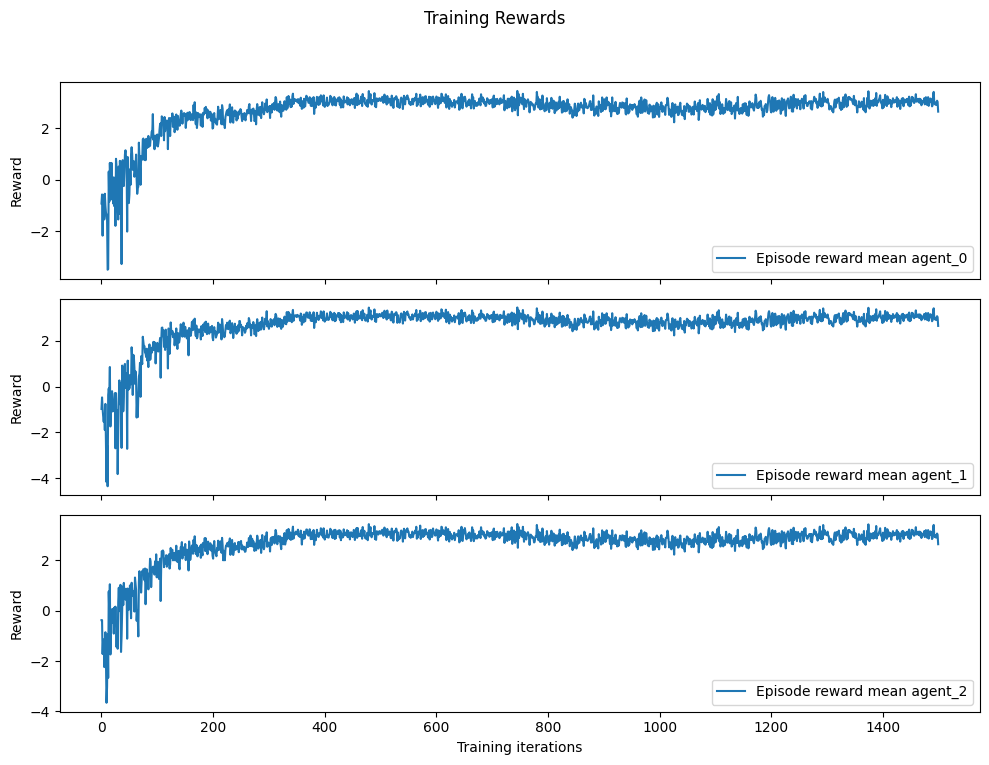

In [9]:
fig, axs = plt.subplots(n_agents, 1, figsize=(10, 8), sharex=True)
if n_agents == 1:
    axs = [axs]
for i, group in enumerate(env.group_map.keys()):
    axs[i].plot(episode_reward_mean_map[group], label=f"Episode reward mean {group}")
    axs[i].set_ylabel("Reward")
    axs[i].legend()
axs[-1].set_xlabel("Training iterations")
fig.suptitle("Training Rewards")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Evaluation and Rendering

In [ ]:
print("Starting evaluation and rendering...")

# Create a single environment for rendering
render_env = VmasEnv(
    scenario=scenario_name,
    num_envs=1,
    continuous_actions=True,
    max_steps=max_steps,
    device=device,
    n_agents=n_agents,
    group_map=custom_group_map,
)

td = render_env.reset()
frames = []

# Rollout Loop
with torch.no_grad():
    for _ in range(max_steps):
        # 1. Run policies to get actions
        for group in render_env.group_map.keys():
            td = policies[group](td)

        # 2. Step the environment
        td_next = render_env.step(td)

        # 3. Use the new observation for the next policy call
        td = td_next.get("next").clone()

        # 4. Reset if the episode terminated
        if td_next.get("done").item():
            td = render_env.reset()

        # 5. Render the frame and append to list
        frame = render_env.render(mode="rgb_array")
        frames.append(Image.fromarray(frame))

# Save the rollout as a GIF
gif_path = f"{scenario_name}_evaluation.gif"
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
)
print(f"✅ Saved animation as {gif_path}")

## Part 4

Based on your understanding of the differences between MADDPG and IDDPG, modify the necessary sections of your MADDPG implementation to convert it into its independent variant (IDDPG). Run the modified code, clearly explain the changes you made and the rationale behind each modification, and finally analyze and discuss the differences you observe between the performance of MADDPG and IDDPG.

## IDDPG

In [ ]:
target_policies, exploration_policies, policies = part1()

critics = part2(centralized=False)

shared_replay_buffer, losses, target_updaters, optimisers = part3_a()

res = part3_b(centralized=False)    # IDDPG
policies = res["policies"]          # learned deployable actors
episode_reward_mean_map = res["episode_rewards"]

Model and policy structure ready for review.
Losses, optimizers, and replay buffer are ready.


Iter [1500/1500] | Rewards: agent_0: 1.88 | agent_1: 1.88 | agent_2: 1.88: 100%|██████████| 1500/1500 [54:02<00:00,  2.16s/it]


Training finished.


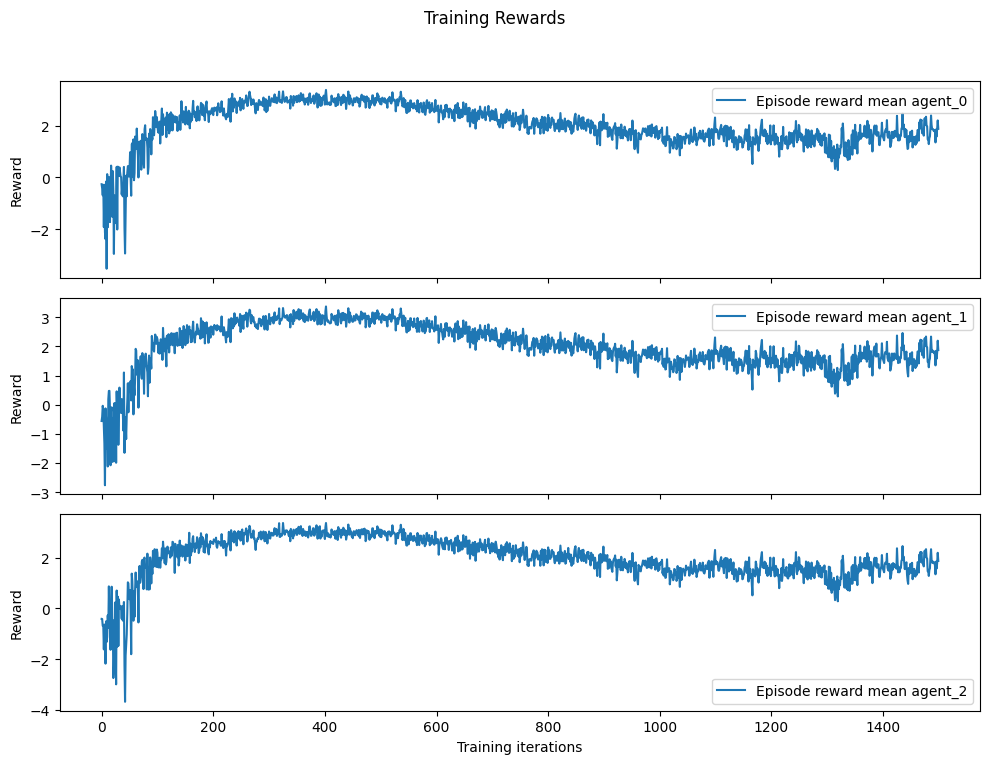

In [12]:
fig, axs = plt.subplots(n_agents, 1, figsize=(10, 8), sharex=True)
if n_agents == 1:
    axs = [axs]
for i, group in enumerate(env.group_map.keys()):
    axs[i].plot(episode_reward_mean_map[group], label=f"Episode reward mean {group}")
    axs[i].set_ylabel("Reward")
    axs[i].legend()
axs[-1].set_xlabel("Training iterations")
fig.suptitle("Training Rewards")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Starting evaluation and rendering...
✅ Saved animation as navigation_evaluation.gif


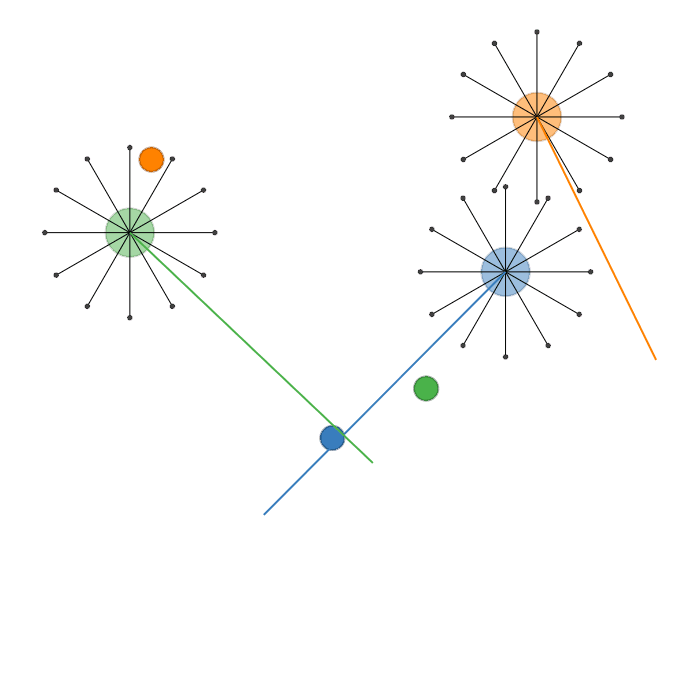

In [13]:
print("Starting evaluation and rendering...")

# Create a single environment for rendering
render_env = VmasEnv(
    scenario=scenario_name,
    num_envs=1,
    continuous_actions=True,
    max_steps=max_steps,
    device=device,
    n_agents=n_agents,
    group_map=custom_group_map,
)

td = render_env.reset()
frames = []

# Rollout Loop
with torch.no_grad():
    for _ in range(max_steps):
        # 1. Run policies to get actions
        for group in render_env.group_map.keys():
            td = policies[group](td)

        # 2. Step the environment
        td_next = render_env.step(td)

        # 3. Use the new observation for the next policy call
        td = td_next.get("next").clone()

        # 4. Reset if the episode terminated
        if td_next.get("done").item():
            td = render_env.reset()

        # 5. Render the frame and append to list
        frame = render_env.render(mode="rgb_array")
        frames.append(Image.fromarray(frame))

# Save the rollout as a GIF
gif_path = f"{scenario_name}_evaluation.gif"
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0,
)
print(f"✅ Saved animation as {gif_path}")

# To display the GIF in a Jupyter notebook, you can use the following:
from IPython.display import Image as IPImage
IPImage(filename=gif_path)